# ML para predecir el gesto

Creación y evaluación de modelos de Machine Learning para predecir qué gesto está realizando el paciente

In [24]:
# ---------- importar librerías---------
# Manipular los datos
import pandas as pd
import numpy as np

# Gráficas
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
sns.set_theme(style="darkgrid")

# scikit-learn (ML en python)
## Procesar el dataset
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
## Modelos ML
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
## Evaluación de los modelos
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score
## Hiperparametrizacion
from sklearn.model_selection import GridSearchCV
## Seleccion de variables
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import RFECV # recursive

# Para ignorar los FutureWarning
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)

In [25]:
#---------Importar los datos-----------
# Dataframe medidas calculadas por repetición
df = pd.read_csv('../csvFiles/medidasPerRepetition.csv', dtype=object) # salida de leer_dataset.ipynb
df.head() # visualizacion de la cabecera

,SubjectID,GestureLabel,RepetitionNumber,CorrectLabel,Position,Duration,HipAngleLeft_standardDeviation,RightArmAngle_standardDeviation,KneeAngleLeft_standardDeviation,AnkleAngleLeft_standardDeviation,...,ElbowAngleRight_Kurtosis,LeftArmAngle_Kurtosis,ShoulderAngleRight_Kurtosis,WristAngleLeft_Kurtosis,ElbowAngleLeft_Kurtosis,WristAngleRight_Kurtosis,ShoulderAngleLeft_Kurtosis,HipAngleRight_Kurtosis,ArmsTogetherAngle_Kurtosis,AnkleAngleRight_Kurtosis
0,101,0,1,1,stand,59,0.3608677355979031,2.7655574767746303,0.20870629032593843,0.6581472034160547,...,-1.5096047609935206,0.5374402120462101,0.24725567691914474,-1.1548519667455222,-0.9176895137907444,0.19853266525825441,-0.6351422949522179,-0.9240468871850966,-0.6043028159859238,-0.40440680981149635
1,101,0,2,1,stand,44,0.11857848631771781,2.2982802008603884,0.22148909073910306,0.8313514219454735,...,-1.280617105642371,0.7268055218978855,-1.7517830977424425,-0.7701703570143632,0.4187723636318532,1.0481449056142007,-0.9030033089456406,-0.19860783889835965,0.8934212147732565,-0.276497605679932
2,101,0,3,1,stand,53,0.24619052972163322,3.445303563459787,0.20016295285928792,0.9602665690153961,...,-1.4552465068519256,0.1405061114156383,0.7198891878500557,-0.5806536048592652,-0.76127983523148,-0.3931234568509234,0.412760624339358,-1.007601590228747,-0.4138693928861996,-0.5305323879118911
3,101,0,4,1,stand,57,0.28321350295077613,3.626021938955907,0.3449046585971368,0.5731684465708434,...,-1.51459552588099,1.0602340465863236,0.4958653590427531,-0.13640312363512264,-0.5844906010216535,-0.6109341257432597,-1.3306916169093075,-1.4875437672995169,-1.2588076707533085,-0.057357413926721
4,101,0,5,1,stand,60,0.39363598833851376,3.767306517718122,0.2176579492233252,0.6589984240898876,...,-1.3601464899179059,-1.527706279445947,0.39390720825161907,-0.42688443195923,-0.5349520236928611,-1.1701446029912246,-0.8445014311637222,-1.4273439546363045,-0.33874666284848587,-0.32227339359147944


## 1. Preprocesado

### 1.1 Codificar variables

In [3]:
# ------Preparar el dataset-------
encoder = OrdinalEncoder(categories=[list(set(df["Position"].values))])
encoder.fit(df[["Position"]])
df["Position"] = encoder.transform(df[["Position"]])

# pasar variable obj to numeric
df = df.apply(pd.to_numeric, errors='ignore')

### 1.2 Dividir el dataset

In [4]:
# Dividimos en train y test
df_train, df_test = train_test_split(df, test_size = 0.3, stratify=df['GestureLabel'])

# Dividimos el conjunto de train en varibales independientes y en target
train_X = df_train.drop(['GestureLabel'], axis = 1)
train_y = pd.DataFrame(df_train['GestureLabel'])

# Dividimos el conjunto de test
test_X = df_test.drop(['GestureLabel'], axis = 1)
test_y = pd.DataFrame(df_test['GestureLabel'])

# Convertimos los df de target (y) a 1-d
train_y = train_y.values.ravel()
test_y = test_y.values.ravel()


## 2. Modelos de ML
Se ha creado una función para entrenar y evaluar los modelos

In [5]:
#-------Funcion para entrenar los modelos-----------
def aplicar_modelos(modelos: list, X:pd.DataFrame, y:pd.DataFrame, tX:pd.DataFrame, ty:pd.DataFrame):
   """
   Aplica una lista de modelos de aprendizaje automático a los datos de prueba y muestra
   los informes de evaluación.

   Parámetros:
   modelos (list): Lista de modelos de aprendizaje automático a evaluar.
   * X: datos de entrenamiento.
   * y: target de entrenamiento.
   * tX: datos de prueba.
   * ty: target de prueba.
   """
   # Iteramos sobre los modelos
   for modelo in modelos:
      modelo.fit(X,y) # entrenamos el modelo
      prediction = modelo.predict(tX) #  predicciones en los datos de prueba
      report = classification_report(ty, prediction, zero_division=0) # informe de evaluación
      print(f"\nModelo: {modelo.__class__.__name__}") 
      print(report) 

In [6]:
# creación de los modelos
knn = KNeighborsClassifier(n_neighbors=1) # K-Neighbors classifier
dtree = DecisionTreeClassifier() # Decision tree
nb = GaussianNB() # Naive Bayes
svm = SVC() # Suport Vector Machine
rf = RandomForestClassifier(n_estimators = 5)  # Random Forest
lr = LogisticRegression(max_iter = 3000) # ¿o usar StandardScaler?

models = [knn, dtree, nb, svm, rf, lr]

# entrenamiento + evaluación
aplicar_modelos(models, train_X, train_y, test_X, test_y)


Modelo: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        77
           1       0.91      0.95      0.93        84
           2       0.77      0.81      0.79       113
           3       0.83      0.78      0.81        96
           4       0.81      0.75      0.78        83
           5       0.79      0.78      0.78        77
           6       0.94      0.94      0.94        78
           7       0.90      0.94      0.92        82
           8       0.90      0.87      0.89        87

    accuracy                           0.85       777
   macro avg       0.86      0.86      0.86       777
weighted avg       0.85      0.85      0.85       777


Modelo: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        77
           1       0.96      0.98      0.97        84
           2       0.94      0.82      0.88       113
           3    

* Confusion matrix: cuanto más valores en la diagonal mejor
* Precision: cuanto más alta mejor
* Recall: cuanto más alta mejor
* F1-measure o F-score: cuanto más alta mejor
* Accuracy: cuanto más alta mejor

En la mayoría de ejecutiones los mejores son **DecisionTreeClassifier**, **KNeighborsClassifier** o **Regresión logistica**

In [7]:
#-----------Función matriz de confusión-----
def plot_confusion_matrix(modelo, tX, ty):
    """
    Grafica la matriz de confusión para un modelo dado.

    Parámetros:
    * modelo: El modelo de clasificación entrenado.
    * tX: Los datos de prueba.
    * ty: Los valores reales del target para los datos de prueba.
    """
    prediction = modelo.predict(tX)
    cm = confusion_matrix(ty, prediction)
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, cmap="Blues")
    plt.title('Confusion Matrix ' + modelo.__class__.__name__)
    plt.show()


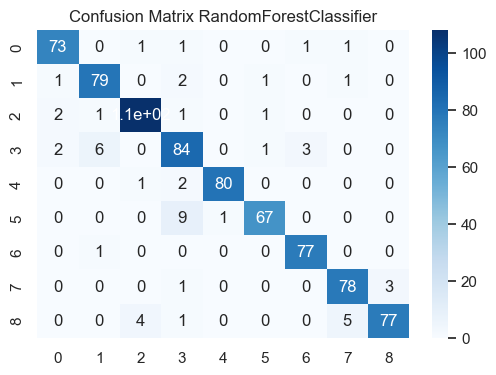

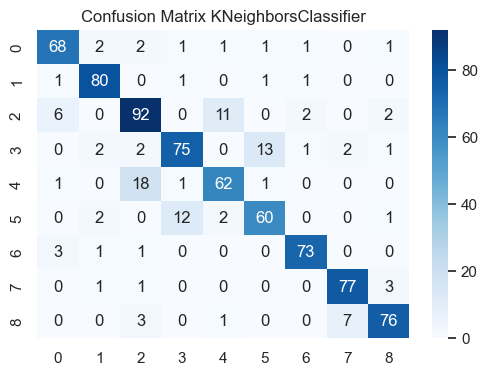

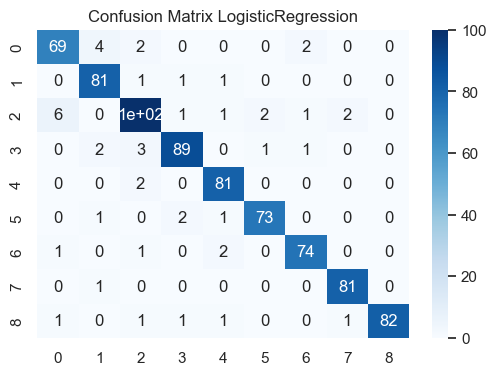

In [8]:
# Confusion Matrix para mejores modelos
plot_confusion_matrix(rf, test_X, test_y)
plot_confusion_matrix(dtree, test_X, test_y)
plot_confusion_matrix(lr, test_X, test_y)

## 3. Hipermetrización

In [9]:
#-------------Parametros---------------
param_grid_knn = {'n_neighbors': [1, 3, 5, 7, 9]}

param_grid_dtree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50]
}

param_grid_nb = {'var_smoothing': np.logspace(0,-9, num=100)}

param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

param_grid_rf = {
    'n_estimators': [5, 10, 50, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50]
}

param_grid_lr = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}

In [10]:
# GridSearchCV instances
gs_knn = GridSearchCV(knn, param_grid_knn, cv=5, scoring='accuracy')
gs_dtree = GridSearchCV(dtree, param_grid_dtree, cv=5, scoring='accuracy')
gs_nb = GridSearchCV(nb, param_grid_nb, cv=5, scoring='accuracy')
gs_svm = GridSearchCV(svm, param_grid_svm, cv=5, scoring='accuracy')
gs_rf = GridSearchCV(rf, param_grid_rf, cv=5, scoring='accuracy')
gs_lr = GridSearchCV(lr, param_grid_lr, cv=5, scoring='accuracy')
# El parámetro cv=5 en GridSearchCV especifica una validación cruzada
# de 5 particiones (5-fold cross-validation)


In [11]:
def aplicar_hiperparametrizacion(modelos: list, X, y):
    for modelo in modelos:
        modelo.fit(X, y)
        print(f"\nModelo: {modelo.estimator.__class__.__name__}") 
        # print(modelo.cv_results_) 
        print("Best parameters: ", modelo.best_params_)
        print("Best score: ", modelo.best_score_)

In [12]:
modelos_gs = [gs_knn, gs_dtree, gs_nb, gs_svm]

aplicar_hiperparametrizacion(modelos_gs, train_X, train_y)


Modelo: KNeighborsClassifier
Best parameters:  {'n_neighbors': 1}
Best score:  0.8460420376542928

Modelo: DecisionTreeClassifier
Best parameters:  {'criterion': 'entropy', 'max_depth': 40}
Best score:  0.912789370348386

Modelo: GaussianNB
Best parameters:  {'var_smoothing': 4.328761281083053e-06}
Best score:  0.7627064213201832

Modelo: SVC
Best parameters:  {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best score:  0.9481256563627232

Modelo: RandomForestClassifier
Best parameters:  {'criterion': 'entropy', 'max_depth': 20, 'n_estimators': 100}
Best score:  0.9619180250521285


C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab


Modelo: LogisticRegression
Best parameters:  {'C': 0.001, 'penalty': 'l2'}
Best score:  0.9448107392356514


C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [13]:
def test_hiperparametrizacion(modelos, tX, ty):
       for modelo in modelos:
            best_modelo = modelo.best_estimator_ 
            prediction = best_modelo.predict(tX) #  predicciones en los datos de prueba
            report = classification_report(ty, prediction, zero_division=0) # informe de evaluación
            print(f"\nModelo: {modelo.estimator.__class__.__name__}") 
            print(report) 

test_hiperparametrizacion(modelos_gs, test_X, test_y)


Modelo: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        77
           1       0.91      0.95      0.93        84
           2       0.77      0.81      0.79       113
           3       0.83      0.78      0.81        96
           4       0.81      0.75      0.78        83
           5       0.79      0.78      0.78        77
           6       0.94      0.94      0.94        78
           7       0.90      0.94      0.92        82
           8       0.90      0.87      0.89        87

    accuracy                           0.85       777
   macro avg       0.86      0.86      0.86       777
weighted avg       0.85      0.85      0.85       777


Modelo: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.90      0.83      0.86        77
           1       0.95      0.95      0.95        84
           2       0.93      0.85      0.89       113
           3    

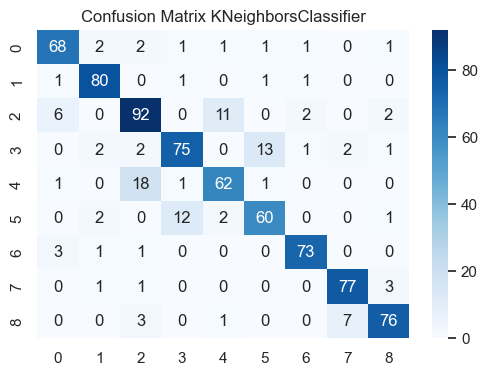

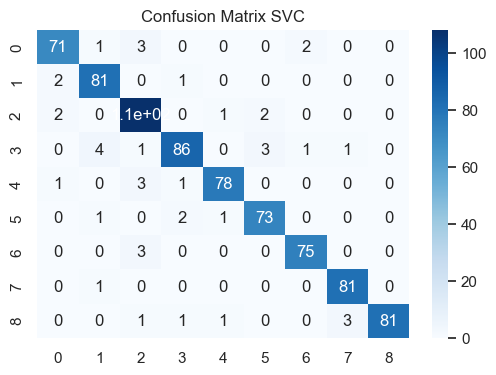

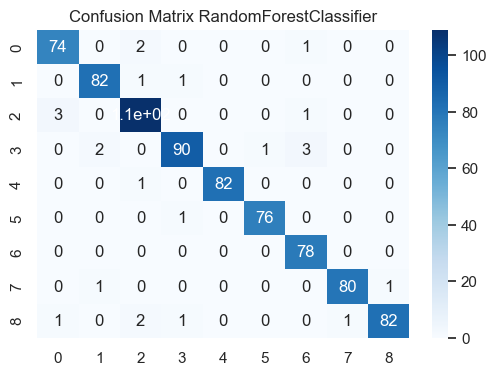

In [14]:
# Confusion Matrix para mejores modelos
plot_confusion_matrix(gs_svm.best_estimator_ , test_X, test_y)
plot_confusion_matrix(gs_rf.best_estimator_ , test_X, test_y)


In [15]:
df_X = df.drop(['GestureLabel'], axis = 1)
df_copy = df.copy()
df_copy['Prediction'] = gs_svm.predict(df_X)

# Insertar las nuevas columnas en las posiciones deseadas
df_copy.insert(2, 'Prediction', df_copy.pop('Prediction')) 

# Ordenar el DataFrame
df_copy['RepetitionNumber'] = df_copy['RepetitionNumber'].astype(int)
df_sorted = df_copy.sort_values(by=['SubjectID', 'GestureLabel', 'RepetitionNumber'])

# Ajustar la configuración de pandas para mostrar todas las filas
#pd.set_option('display.max_rows', None)

# Mostrar todas las filas del DataFrame
df_sorted 

,SubjectID,GestureLabel,Prediction,RepetitionNumber,CorrectLabel,Position,Duration,HipAngleLeft_standardDeviation,RightArmAngle_standardDeviation,KneeAngleLeft_standardDeviation,...,ElbowAngleRight_Kurtosis,LeftArmAngle_Kurtosis,ShoulderAngleRight_Kurtosis,WristAngleLeft_Kurtosis,ElbowAngleLeft_Kurtosis,WristAngleRight_Kurtosis,ShoulderAngleLeft_Kurtosis,HipAngleRight_Kurtosis,ArmsTogetherAngle_Kurtosis,AnkleAngleRight_Kurtosis
0,101,0,0,1,1,1.0,59,0.360868,2.765557,0.208706,...,-1.509605,0.537440,0.247256,-1.154852,-0.917690,0.198533,-0.635142,-0.924047,-0.604303,-0.404407
1,101,0,0,2,1,1.0,44,0.118578,2.298280,0.221489,...,-1.280617,0.726806,-1.751783,-0.770170,0.418772,1.048145,-0.903003,-0.198608,0.893421,-0.276498
2,101,0,0,3,1,1.0,53,0.246191,3.445304,0.200163,...,-1.455247,0.140506,0.719889,-0.580654,-0.761280,-0.393123,0.412761,-1.007602,-0.413869,-0.530532
3,101,0,0,4,1,1.0,57,0.283214,3.626022,0.344905,...,-1.514596,1.060234,0.495865,-0.136403,-0.584491,-0.610934,-1.330692,-1.487544,-1.258808,-0.057357
4,101,0,0,5,1,1.0,60,0.393636,3.767307,0.217658,...,-1.360146,-1.527706,0.393907,-0.426884,-0.534952,-1.170145,-0.844501,-1.427344,-0.338747,-0.322273
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2584,307,8,8,8,1,1.0,48,8.563372,1.555034,6.503301,...,0.234936,-0.781945,0.465005,-0.949755,-0.872651,0.056064,-0.971195,-1.014746,-0.339300,-0.270964
2585,307,8,8,9,1,1.0,48,7.609432,1.332626,6.647659,...,-0.759991,-1.644095,-0.019000,0.520658,-1.114747,-1.006323,-0.963412,-1.651462,-0.863515,-1.671159
2586,307,8,8,10,1,1.0,47,6.656025,1.315829,5.285898,...,-0.707586,-0.826005,-1.203659,-0.834273,-0.267076,-0.776532,0.037584,-1.103517,-0.449516,-2.061997
2587,307,8,8,11,1,1.0,51,7.627692,1.896625,6.237513,...,-0.899253,-0.620023,-0.087088,-0.261026,-0.983178,-0.052683,-0.660478,-1.697380,-0.445218,-1.011064


## 4. Feature Selection

### 4.1 SelectKBest

In [16]:
# Definimos feature Selection K=40 (selecciona entonces las 40 variables que considere mas importantes)
feature_selection=SelectKBest(k=40)

# Fit Feature Selection (entrena y hace una tranfosmada)
feature_selection.fit_transform(train_X, train_y)

# Selecionamos las características mas relevantes para nuestro problema
selected = feature_selection.get_support(indices=True)
print(train_X.columns[selected])

Index(['RightArmAngle_standardDeviation', 'ElbowAngleRight_standardDeviation',
       'LeftArmAngle_standardDeviation',
       'ShoulderAngleRight_standardDeviation',
       'ElbowAngleLeft_standardDeviation',
       'ShoulderAngleLeft_standardDeviation',
       'HipAngleRight_standardDeviation',
       'ArmsTogetherAngle_standardDeviation', 'ElbowAngleRight_Maximum',
       'ShoulderAngleRight_Maximum', 'ElbowAngleLeft_Maximum',
       'ShoulderAngleLeft_Maximum', 'RightArmAngle_Minimum',
       'LeftArmAngle_Minimum', 'ShoulderAngleLeft_Minimum',
       'ArmsTogetherAngle_Minimum', 'RightArmAngle_Mean', 'LeftArmAngle_Mean',
       'ShoulderAngleLeft_Mean', 'ArmsTogetherAngle_Mean',
       'RightArmAngle_Range', 'ElbowAngleRight_Range', 'LeftArmAngle_Range',
       'ShoulderAngleRight_Range', 'ElbowAngleLeft_Range',
       'ShoulderAngleLeft_Range', 'ArmsTogetherAngle_Range',
       'RightArmAngle_Variance', 'ElbowAngleRight_Variance',
       'LeftArmAngle_Variance', 'ElbowAngleLeft_V

### 4.2 Entrenar con las variables sleccionadas

In [17]:
# creación de los modelos
knn_fs = KNeighborsClassifier(n_neighbors=1) # K-Neighbors classifier
dtree_fs = DecisionTreeClassifier() # Decision tree
nb_fs = GaussianNB() # Naive Bayes
svm_fs = SVC() # Suport Vector Machine
rf_fs = RandomForestClassifier(n_estimators = 5)  # Random Forest
lr_fs = LogisticRegression(max_iter = 500) # ¿o usar StandardScaler?

models_fs = [knn_fs, dtree_fs, nb_fs, svm_fs, rf_fs, lr_fs]


In [18]:
# Reduce train_X to the selected features with .transform(X)
#creamos un data frame vacio para hacer una tabla donde esten 
# las variables con la trsnformada de la X.
# esto elimina las variales que no nos intersan.

X_fs = pd.DataFrame(feature_selection.transform(train_X),
                 columns=train_X.columns[selected])
# train -> train and validation
X_fs_train, X_validation, y_fs_train, y_validation = train_test_split(X_fs, train_y, train_size=0.7,random_state=42)


aplicar_modelos(models_fs, X_fs_train, y_fs_train, X_validation, y_validation)


Modelo: KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.94      0.85      0.89        53
           1       0.90      0.97      0.93        62
           2       0.70      0.76      0.73        76
           3       0.74      0.75      0.74        67
           4       0.73      0.67      0.70        64
           5       0.73      0.67      0.70        54
           6       0.97      0.94      0.95        62
           7       0.84      0.86      0.85        49
           8       0.82      0.86      0.84        57

    accuracy                           0.81       544
   macro avg       0.82      0.81      0.81       544
weighted avg       0.81      0.81      0.81       544


Modelo: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.98      0.89      0.93        53
           1       0.82      0.94      0.87        62
           2       0.89      0.89      0.89        76
           3    

C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 4.3 Recursive feature elimination

In [19]:
dtree_rfe = DecisionTreeClassifier() # Decision tree
rf_rfe = RandomForestClassifier(n_estimators = 5)  # Random Forest
lr_rfe = LogisticRegression(max_iter = 500) # ¿o usar StandardScaler?

In [20]:
models_with_coef = [dtree_rfe, rf_rfe, lr_rfe]

In [21]:
def seleccion_variables(models, X, y):
    for model in models:
        rfecv = RFECV(
            estimator=model,
            scoring="accuracy",
            n_jobs=2 # Number of cores to run in parallel while fitting across folds. 
        )
        rfecv.fit(X, y)
        print(f"\nModelo: {rfecv.estimator.__class__.__name__}") 
        print(f"Optimal number of features: {rfecv.n_features_}")
        selected = rfecv.get_feature_names_out()
        print(selected)
        
        X_rfe= train_X[selected]
        # train -> train and validation
        X_rfe_train, X_validation, y_rfe_train, y_validation = train_test_split(X_rfe, y, train_size=0.7,random_state=42)
        aplicar_modelos([model], X_rfe_train, y_rfe_train, X_validation, y_validation)

seleccion_variables(models_with_coef, train_X, train_y)


Modelo: DecisionTreeClassifier
Optimal number of features: 14
['RightArmAngle_Maximum' 'ElbowAngleRight_Maximum'
 'ShoulderAngleRight_Maximum' 'ShoulderAngleLeft_Maximum'
 'HipAngleRight_Maximum' 'RightArmAngle_Minimum' 'LeftArmAngle_Minimum'
 'RightArmAngle_Mean' 'ShoulderAngleLeft_Mean' 'HipAngleLeft_Range'
 'KneeAngleLeft_Range' 'LeftArmAngle_Range' 'ElbowAngleLeft_Variance'
 'ArmsTogetherAngle_CoV']

Modelo: DecisionTreeClassifier
              precision    recall  f1-score   support

           0       0.90      0.87      0.88        53
           1       0.97      1.00      0.98        62
           2       0.91      0.93      0.92        76
           3       0.83      0.82      0.83        67
           4       0.91      0.95      0.93        64
           5       0.84      0.80      0.82        54
           6       0.90      0.92      0.91        62
           7       0.86      0.88      0.87        49
           8       0.96      0.91      0.94        57

    accuracy      

C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab


Modelo: LogisticRegression
Optimal number of features: 51
['RepetitionNumber' 'RightArmAngle_standardDeviation'
 'LeftArmAngle_standardDeviation' 'WristAngleLeft_standardDeviation'
 'ElbowAngleLeft_standardDeviation' 'WristAngleRight_standardDeviation'
 'HipAngleLeft_Maximum' 'RightArmAngle_Maximum' 'KneeAngleRight_Maximum'
 'ElbowAngleRight_Maximum' 'LeftArmAngle_Maximum'
 'ShoulderAngleRight_Maximum' 'ElbowAngleLeft_Maximum'
 'ShoulderAngleLeft_Maximum' 'HipAngleRight_Maximum'
 'ArmsTogetherAngle_Maximum' 'HipAngleLeft_Minimum'
 'RightArmAngle_Minimum' 'KneeAngleLeft_Minimum' 'KneeAngleRight_Minimum'
 'LeftArmAngle_Minimum' 'ShoulderAngleRight_Minimum'
 'WristAngleRight_Minimum' 'ShoulderAngleLeft_Minimum'
 'ArmsTogetherAngle_Minimum' 'RightArmAngle_Mean' 'KneeAngleLeft_Mean'
 'AnkleAngleLeft_Mean' 'ElbowAngleRight_Mean' 'LeftArmAngle_Mean'
 'ShoulderAngleRight_Mean' 'ElbowAngleLeft_Mean' 'ShoulderAngleLeft_Mean'
 'HipAngleRight_Mean' 'ArmsTogetherAngle_Mean' 'AnkleAngleRight_Mean'


C:\Users\nerea\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
